In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
np.random.randint(10)

5

In [3]:
class AksaraBali(Dataset):
    def __init__(self, csv_file, root_dir, setSize, height=105, width=105, transform=None):        
        csvFile = pd.read_csv(csv_file, header=None)
        self.csv_file = csvFile
        self.root_dir = root_dir
        self.setSize = setSize
        self.transform = transform
        self.categories = csvFile[2].unique()
        self.height = height
        self.width = width
    
    def __len__(self):
        return self.setSize

    def __getitem__(self, index):
        img1 = None
        img2 = None
        label = None

        if index % 2 == 0:
            category = random.choice(self.categories)
            img1_path = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category][0].values))
            img2_path = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category][0].values))
            img1 = Image.open(img1_path).resize((self.height, self.width))
            img2 = Image.open(img2_path).resize((self.height, self.width))
            label = 1.0

        else:
            category1, category2 = random.choice(self.categories), random.choice(self.categories)
            img1_path = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category1][0].values))
            img2_path = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category2][0].values))
            while img1_path == img2_path:
                img2_path = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category2][0].values))
            img1 = Image.open(img1_path).resize((self.height, self.width))
            img2 = Image.open(img2_path).resize((self.height, self.width))
            label = 0.0
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

In [4]:
class NWayOneShotEvalSet(Dataset):
    def __init__(self, csv_file, root_dir, setSize, numWay, height=105, width=105, transform=None):
        self.csv_file = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.setSize = setSize
        self.transform = transform
        self.categories = self.csv_file[2].unique()
        self.height = height
        self.width = width
        self.numWay = numWay

    def __len__(self):
        return self.setSize

    def __getitem__(self, idx):
        # find one main image
        category =  random.choice(self.categories) # find main class label
        imgDir = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category][0].values)) # find random img in main class label
        mainImg = Image.open(imgDir).resize((self.height, self.width)) # open img
        if self.transform:
            mainImg = self.transform(mainImg)
        
        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        label = np.random.randint(self.numWay)
        for i in range(self.numWay):
            if i == label:
                imgDirTest = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category][0].values))
                while imgDir == imgDirTest:
                    imgDirTest = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==category][0].values))
            else:
                categoryTest = random.choice(self.categories)
                while category == categoryTest:
                    categoryTest = random.choice(self.categories)
                imgDirTest = os.path.join(self.root_dir, random.choice(self.csv_file[self.csv_file[2]==categoryTest][0].values))
            testImg = Image.open(imgDirTest).resize((self.height, self.width))
            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg)
        
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype= int))        

In [5]:
# test dataset
TrainRoot_dir = '../data/Train Original/'
TrainCsv_file = '../data/Train Original/trainOri_label.csv'

TestRoot_dir = '../data/Test/'
TestCsv_file = '../data/Test/test_label.csv'
setSize = 1000
numWay = 10

In [6]:
trainSet = AksaraBali(csv_file=TrainCsv_file, root_dir=TrainRoot_dir, setSize=1)
testSet = NWayOneShotEvalSet(TestCsv_file, TestRoot_dir, setSize, numWay)

tensor([0.])


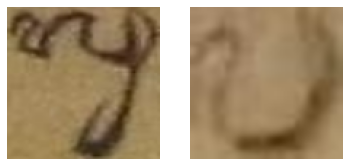

In [7]:
fig, ax = plt.subplots(1, 2)
for i, j in enumerate(trainSet[9]):
    if i < 2:   
        ax[i].axis('off')
        ax[i].imshow(j)        
    else:
        print(j)
plt.show()

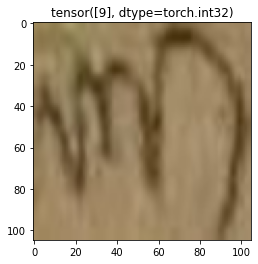

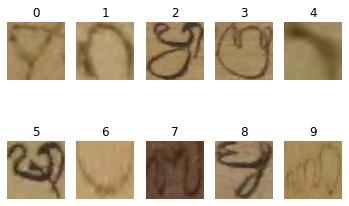

In [8]:
a, b, c = testSet[1]

plt.title(c)
plt.imshow(a)
plt.show()

fig, ax = plt.subplots(2, 5)
for i, axes in enumerate(ax.flat):
    axes.set_title(i)
    axes.axis("off")
    axes.imshow(b[i])
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__
        
        # conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
        
        
    def convs(self, x):
        # out_dim = in_dim - kernel_size + 1
        # 1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x
    
    
    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x
    
    
def train(model, train_loader, val_loader, num_epochs, criterion):
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_running_loss = 0.0
        
        # check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_vall_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_vall_loss)
        print('Epoch [{}/{}], Train Loss : {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_vall_loss))
    print('Finished Training')
    return train_losses, val_losses